In [1]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPool1D, Flatten, RepeatVector
from matplotlib import pyplot as plt
import yfinance as yf
from pandas_datareader.data import DataReader
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import quandl
from fredapi import Fred
import statsmodels.api as sm
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold
from IPython.display import display

fred_key = "df4910b2cad947d95cf6ab16ba11d74d"
fred = Fred(api_key = fred_key)
quandl.ApiConfig.api_key = 'Qq5R29Xiqp2yUbb9dzNq'

DEBUG = False
TRAIN_MODEL = False
INFER_TEST = True
ONE_FOLD_ONLY = False
COMPUTE_LSTM_IMPORTANCE = True

In [2]:
def plot(prediction,target,grey=None,start=None,end=None):
    # if start is None:
    #     start=df.index.min()
    # if end is None:
    #     end=df.index.max()
    # recessions=DataReader('USREC', 'fred', start=start,end=end)['USREC']

    # pd.concat([,target],axis=1,ignore_index=False).plot()
    fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
    
    # if isinstance(df,pd.DataFrame):
    # else:
    #     ylim = (df.min(),df.max())
        

    Results=pd.DataFrame(prediction,index=target.index)
    Results.plot(ax=ax,legend=True)
    Results['target']=target
    ylim = (Results.min().min(),Results.max().max())
    ax.fill_between(Results['target'].index, 0, ylim[1]+1e-2, Results['target'],facecolor='k', alpha=0.1)
    ax.legend(["Prediction", "NBER recession indicator"])
    return fig,ax

In [3]:
MacroCode=pd.read_csv(r'Data\Macro Variables.csv')
MacroCode.replace({'Average HOUST':'HOUST','S&P 500':'SP500'},inplace=True)

errors=[]
indicators={}
freq={}
for code in MacroCode['Variable']:
    if not ('S&P' in code):
        try:
            col=fred.get_series(code).to_frame(code).squeeze()
            if code == 'CPFF':
                indicators[code]=(col) #.resample('MS').last()
            elif code == "ICSA":
                indicators[code]=(col) #.resample('MS').sum()
            elif code == "SP500":
                indicators[code]=(col) #.resample('MS').first()
                # indicators['SP500']=(yf.download('^GSPC')['Close'].to_frame('SP500').squeeze())
            else:
                indicators[code]=(col) # .resample('M').interpolate()
        except ValueError:
            errors.append(code)
indicators['S&P: indust']=(yf.download('^SP500-20')['Close'].to_frame('S&P: indust').squeeze()) # .resample("MS").last()
indicators['S&P div yield']=(quandl.get("MULTPL/SP500_DIV_YIELD_MONTH").squeeze().to_frame('S&P div yield').squeeze()) # .resample("MS").last()
indicators['S&P PE ratio']=(quandl.get("MULTPL/SP500_PE_RATIO_MONTH").squeeze().to_frame('S&P PE ratio').squeeze()) # .resample("MS").first()


if len(errors)>0:
    raise Exception("Erorrs found")
data=pd.concat(indicators,axis=1).copy().fillna(method='ffill')

def deltaX(data):
    return data.diff()

def delta2X(data):
    return data-2*data.shift(1)+data.shift(2)

def logdata(data):
    return np.log(data)

def difflog(data):
    return np.log(data).diff()

def difflog2(data):
    return np.log(data)-2*np.log(data.shift(1))+np.log(data.shift(2))

def diffpercent(data):
    return (data/data.shift() - 1) - (data.shift()/data.shift(2) - 1)



transformation={1:(lambda x: x),
                2:deltaX,
                3:delta2X,
                4:logdata,
                5:difflog,
                6:difflog2,
                7:diffpercent,
                }

df_transformed=pd.DataFrame()

for column in data.columns:
    type=MacroCode[MacroCode['Variable'] == column]['Transformation'].iloc[0]
    df_transformed[column]=transformation[type](data[column])
    df_transformed=df_transformed.copy()

KeyboardInterrupt: 

In [ ]:
# df=yf.download("GE")
# df.head()
n_lookback=30
n_forecast=1

df=df_transformed.copy()
# df=pd.read_csv('Data/Transformed HistoricalVariables.csv',index_col=0,parse_dates=True)
recessions =  DataReader('USRECDM', 'fred', start='1800')
# df[f'in a recession']=recessions
df['target'] = recessions.shift(-250)

df.fillna(method='ffill',inplace=True)
# df=df.fillna(-1)
df=df['1971':] #.resample('MS').last()
print(df.shape)
df.head()

(11123, 125)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES3000000008,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio,target
1971-01-01,0.008594,0.0096,0.013628,0.00975,NaN,0.007663,0.003694,0.003908,0.014828,0.039006,...,0.011976,0.0,0.007963,-0.003878,-0.00768,0.023135,NaN,0.0,0.031962,0.0
1971-01-02,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.011976,0.0,-0.007963,0.003878,0.00768,-0.023135,NaN,0.0,0.000000,0.0
1971-01-09,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0
1971-01-16,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0
1971-01-23,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0


In [ ]:
df_for_training=df[:"1997"]
df_for_validation=df["1998":"2003"]
df_for_testing=df["2003":]
print('df_for_training shape: ',df_for_training.shape)
print('df_for_validation shape: ',df_for_validation.shape)
print('df_for_testing shape: ',df_for_testing.shape)

df_for_training shape:  (3075, 125)
df_for_validation shape:  (1899, 125)
df_for_testing shape:  (6465, 125)


In [ ]:
def createXY(dataset,n_lookback = 60,n_forecast = 3,target_col=-1):
    X = []
    Y = []

    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        X.append(dataset[i - n_lookback: i, 0:dataset.shape[1]-1])
        Y.append(dataset[i: i + n_forecast,target_col])

    return np.array(X),np.array(Y)


In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.fillna(0))
df_for_validing_scaled = scaler.transform(df_for_validation.fillna(0))
df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))


In [ ]:

trainX,trainY=createXY(df_for_training_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
validX,validY=createXY(df_for_validing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
testX,testY=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)

In [ ]:
from tensorflow.keras.layers import LSTM,  Dense, Dropout, Conv1D, MaxPool1D,Flatten,RepeatVector
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential([
     Conv1D(filters=32,kernel_size=(3,),activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]),)
    ,Conv1D(filters=32,kernel_size=(3,),activation='relu')
    ,MaxPool1D(1)
    ,Dropout(0.1)
    ,Flatten()
    ,RepeatVector(1)
    ,LSTM(100, return_sequences=False)
    ,Dense((n_forecast)
           ,activation='sigmoid'
           )
    ])
model.summary()
import tensorflow_addons as tfa


# Define the callback function
class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        # Call the parent method
        super().on_epoch_end(epoch, logs)
        
        # Save the epoch number to a file
        with open('epoch.txt', 'w') as f:
            f.write(str(epoch))
            
model.compile(optimizer='adam',
              metrics=['Recall', 'Precision'],
              loss=tfa.losses.SigmoidFocalCrossEntropy()
              # loss='BinaryCrossentropy'
              )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 32)            11936     
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 26, 32)            0         
                                                                 
 flatten (Flatten)           (None, 832)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 832)           0         
 )                                                      

c:\Users\amine\OneDrive\Documents\PFA\.venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:


PT_path='Model/CNN2-LSTM-TFA'
f1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
f2 = ModelCheckpoint(filepath=PT_path, monitor='recall', mode='max', verbose=1, save_best_only=True)


# fit the model
if TRAIN_MODEL:
    history = model.fit(trainX, trainY, epochs=100, batch_size=320, 
                        validation_data=(validX,validY), 
                        # validation_split=0.1, 
                        verbose=1,  
                        callbacks=[
                                    # f1,
                                    f2
                                ]
                    )


In [11]:
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()
# plt.show();
# plt.plot(history.history['recall'], label='recall')
# plt.plot(history.history['val_recall'], label='validation recall')
# plt.legend()

In [ ]:
BEST_Model=True

202/202 [==============================] - 2s 7ms/step


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

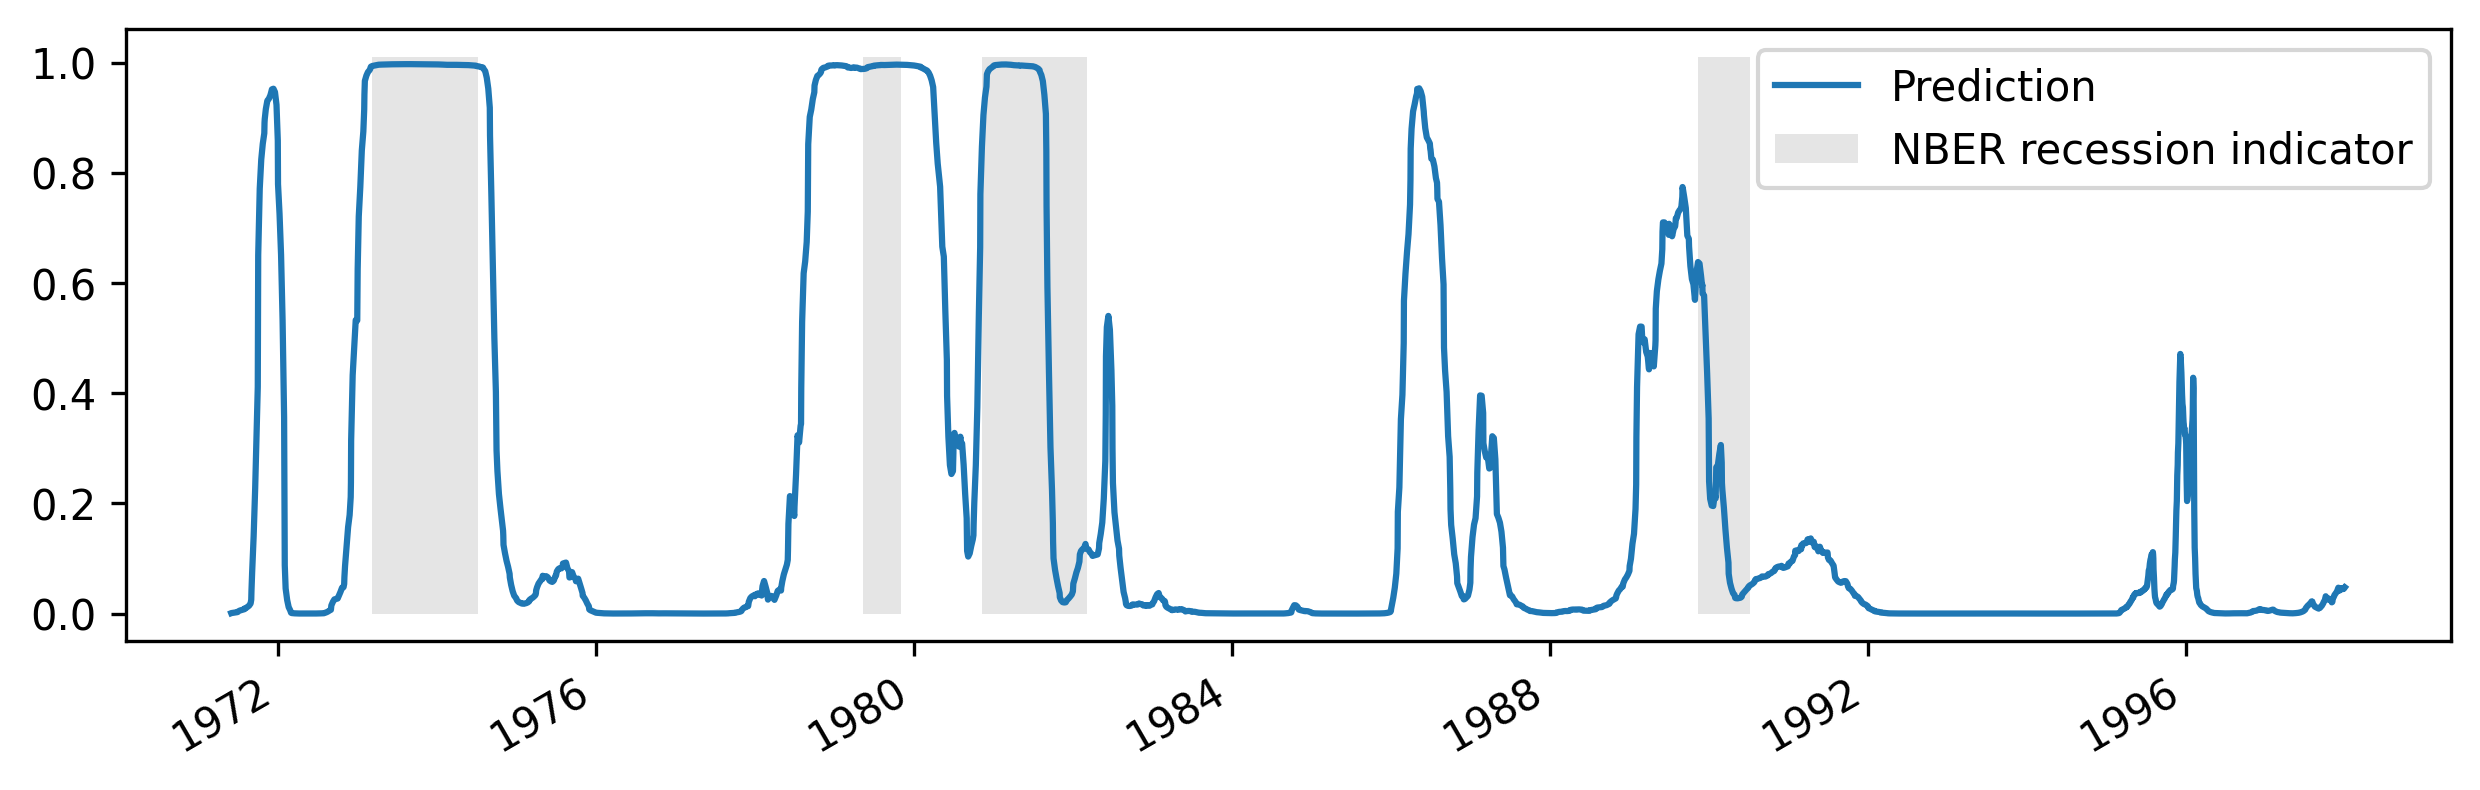

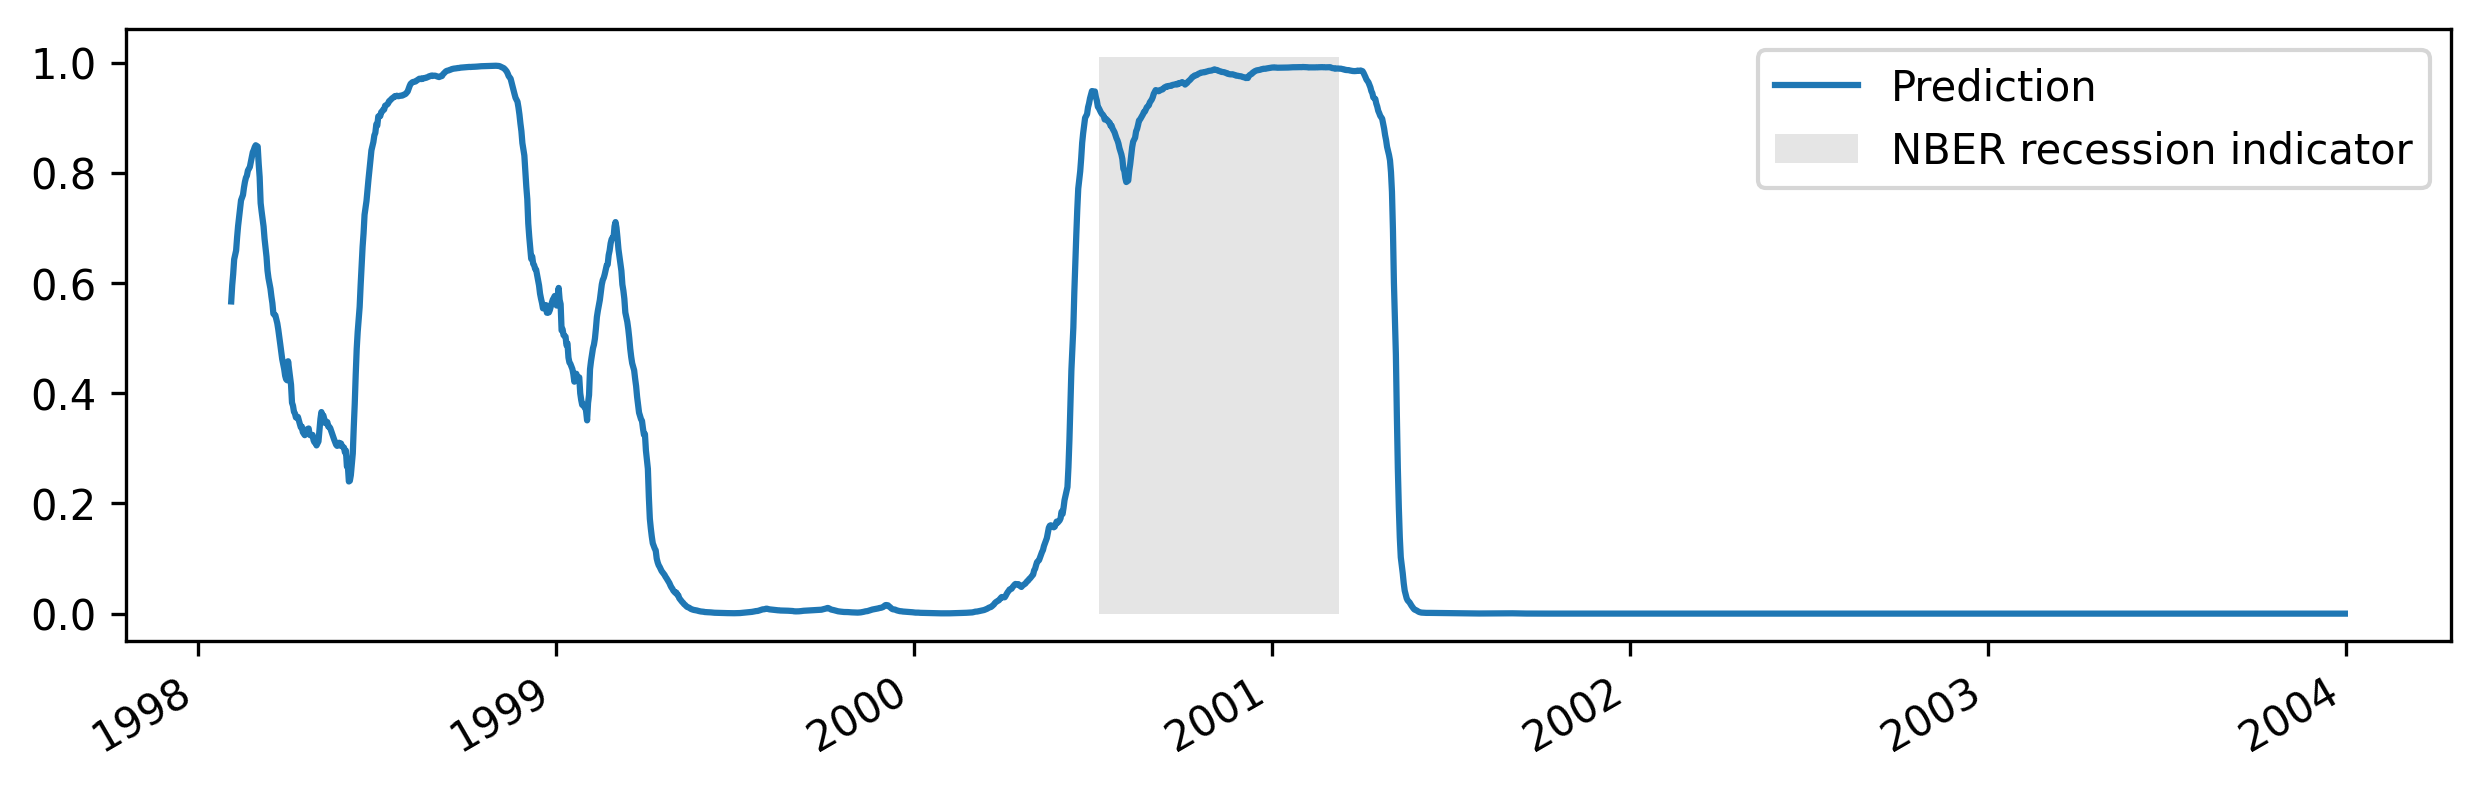

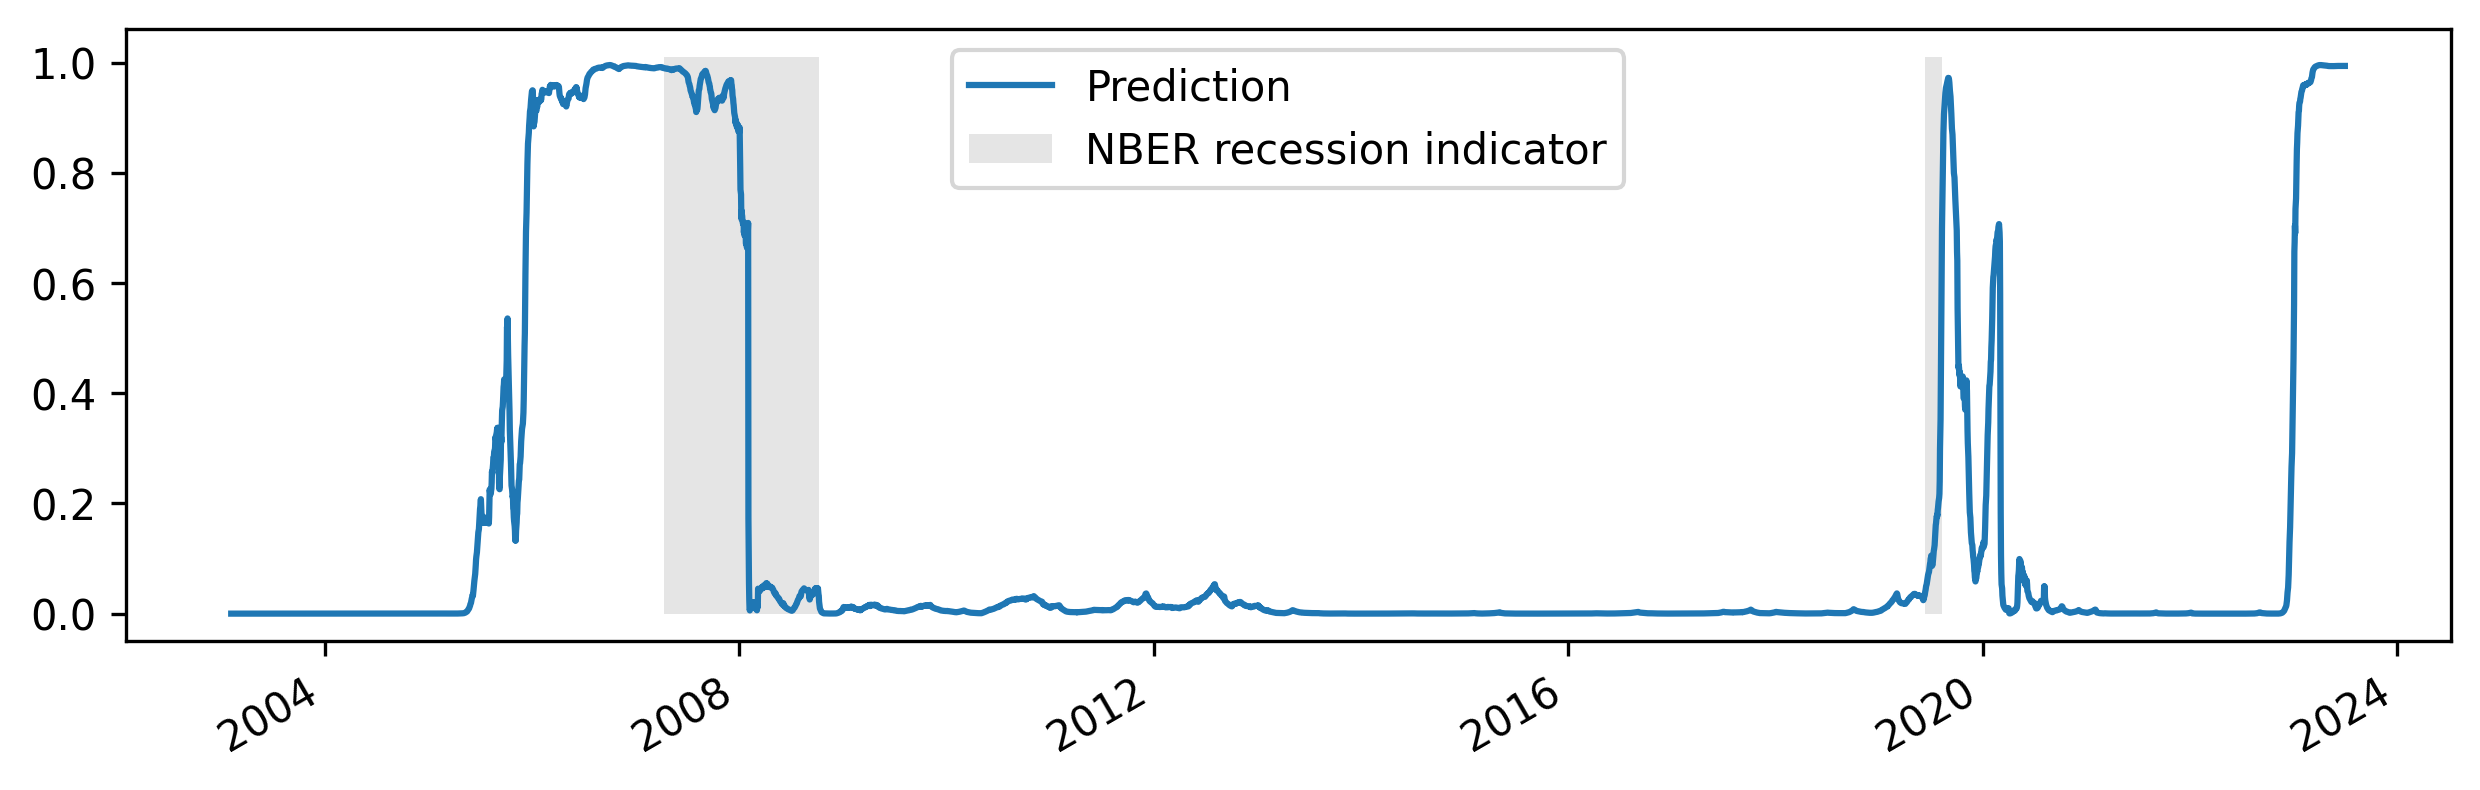

In [ ]:

if BEST_Model:
    model_used = tf.keras.models.clone_model(model)
    model_used.load_weights("Model/CNN2-LSTM-test")
else:
    model_used = model

prediction_train=model_used.predict(trainX)
prediction_valid=model_used.predict(validX)
prediction_test=model_used.predict(testX)


trainResults= pd.DataFrame()
trainResults['Actual']=df_for_training.iloc[-prediction_train.shape[0]:,-1]
trainResults['Pred']=prediction_train
trainResults=trainResults
plot((trainResults['Pred']),trainResults["Actual"])

validResults= pd.DataFrame()
validResults['Actual']=df_for_validation.iloc[-prediction_valid.shape[0]:,-1]
validResults['Pred']=prediction_valid
validResults=validResults
plot((validResults['Pred']),validResults["Actual"])

testResults = pd.DataFrame()
testResults['Actual']=df_for_testing.iloc[-prediction_test.shape[0]:,-1]
testResults["Pred"]=prediction_test
plot(testResults["Pred"],testResults["Actual"])

In [ ]:
testResults["Actual"]

2003-02-05    0.0
2003-02-06    0.0
2003-02-07    0.0
2003-02-08    0.0
2003-02-10    0.0
             ... 
2023-05-31    0.0
2023-06-01    0.0
2023-06-02    0.0
2023-06-05    0.0
2023-06-30    0.0
Name: Actual, Length: 6434, dtype: float64

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def var_importance(model,scaler,df_for_testing,mode='perturbation',std=None,verbose=False):
    metric= lambda x,y: ((x-y) ** 2).mean() ** 0.5
    Cols=df_for_testing.columns[:-1]
    df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))
    testX_,testY_=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
    orig_out = model.predict(testX_,verbose=verbose)
    Output=pd.DataFrame()
    Output.loc['Base',['RMSE']]=[metric(orig_out ,testY_)]
    for i in (range(len(Cols))):  # iterate over the three features
        new_x = testX_.copy()
        
        if mode == "perturbation":
            if std is None:
                var=new_x[:, :, i].std()
            perturbation = np.random.normal(0.0, std, size=new_x.shape[:2])
            new_x[:, :, i] = new_x[:, :, i] + perturbation
        else:
            np.random.shuffle(new_x[:, :, i])
            
        perturbed_out = model.predict(new_x,verbose=0)
        effect=metric(orig_out ,perturbed_out)
        Output.loc[Cols[i],['RMSE']]=[effect]
            
        if verbose:
            print(f'Variable {Cols[i]}, perturbation effect: {effect:.4f}')
    return Output


In [16]:
R=var_importance(model,scaler,df.loc["1999":],"permute",verbose=False)

In [20]:
pd.set_option('display.max_rows', 500)

RR=R.sort_values(["RMSE"],ascending=False)
print(RR)

                     RMSE
Base             0.505314
NONBORRES        0.005249
HOUST            0.004849
HOUSTW           0.004355
AAAFFM           0.003857
PERMITW          0.002670
M1SL             0.002617
CPFF             0.002495
PERMITNE         0.002346
BAAFFM           0.002070
HOUSTMW          0.001897
AWHMAN           0.001833
CES0600000007    0.001823
PERMITS          0.001689
T10YFFM          0.001511
AMBSL            0.001441
TOTALSL          0.001284
HOUSTS           0.001214
HOUSTNE          0.001160
T1YFFM           0.001038
T5YFFM           0.000998
USTPU            0.000806
S&P: indust      0.000794
CE16OV           0.000752
RSXFS            0.000737
S&P PE ratio     0.000718
TOTRESNS         0.000714
PERMIT           0.000706
UEMPMEAN         0.000696
SRVPRD           0.000695
USTRADE          0.000673
PERMITMW         0.000659
UEMP5TO14        0.000610
UNRATE           0.000605
PAYEMS           0.000552
REALLN           0.000534
BUSINV           0.000529
UEMPLT5     

In [21]:
TR=(RR.iloc[1:]/RR.iloc[1:].sum())
TR[['%RMSE']]=(RR.iloc[1:]/RR.iloc[1:].sum())
TR

,RMSE,%RMSE
NONBORRES,0.064583,0.064583
HOUST,0.059655,0.059655
HOUSTW,0.053582,0.053582
AAAFFM,0.047450,0.047450
PERMITW,0.032847,0.032847
M1SL,0.032192,0.032192
CPFF,0.030690,0.030690
PERMITNE,0.028858,0.028858
BAAFFM,0.025468,0.025468
HOUSTMW,0.023342,0.023342


In [22]:
cols=list(RR.index)[:5]
listtt=data.loc['1971':,cols].corr()
mask = np.triu(np.ones_like(listtt, dtype=bool))
listtt

KeyError: "['Base'] not in index"

In [27]:
cols=list(RR.index)[:5]
for name_row in list(RR.index)[:5]:
    CORR=data.loc['1971':,cols].corr()
    mask = np.triu(np.ones_like(CORR, dtype=bool))
    CORR[mask]=np.NaN
    print(CORR)
    break

            BAAFFM  PERMITNE   T10YFFM    PERMIT  AAAFFM
BAAFFM         NaN       NaN       NaN       NaN     NaN
PERMITNE -0.270425       NaN       NaN       NaN     NaN
T10YFFM   0.922196 -0.150839       NaN       NaN     NaN
PERMIT   -0.358749  0.787431 -0.211052       NaN     NaN
AAAFFM    0.973759 -0.234968  0.962471 -0.291844     NaN


In [28]:
cols=list(RR.index)[:]
listtt=data.loc['1971':,cols].corr()
mask = np.triu(np.ones_like(listtt, dtype=bool))
listtt
listtt[mask]=np.NaN

index=[]
for name_row,row in listtt.iterrows():
    row=row.dropna()
    if any(row>0.85):
            index.append(name_row)
index

['T10YFFM',
 'AAAFFM',
 'HOUST',
 'T5YFFM',
 'HOUSTW',
 'PERMITS',
 'HOUSTS',
 'PERMITW',
 'PERMITMW',
 'AWHMAN',
 'CE16OV',
 'USFIRE',
 'PAYEMS',
 'IPDMAT',
 'ACOGNO',
 'TB3SMFFM',
 'SRVPRD',
 'M2REAL',
 'IPFINAL',
 'INDPRO',
 'BUSLOANS',
 'RSXFS',
 'USTRADE',
 'IPMANSICS',
 'S&P: indust',
 'USWTRADE',
 'DPCERA3M086SBEA',
 'CPITRNSL',
 'M2SL',
 'AMDMUO',
 'AMBSL',
 'MANEMP',
 'CMRMTSPL',
 'IPCONGD',
 'IPMAT',
 'IPBUSEQ',
 'TOTRESNS',
 'IPFPNSS',
 'IPDCONGD',
 'USGOVT',
 'CLF16OV',
 'DMANEMP',
 'BUSINV',
 'USCONS',
 'DGORDER',
 'IPB51222S',
 'NEWORDER',
 'IPFUELS',
 'RPI',
 'WPSID61',
 'DTCTHFNM',
 'IPNCONGD',
 'CUSR0000SAD',
 'WPSFD49502',
 'DNDGRG3M086SBEA',
 'CUSR0000SAC',
 'WPSID62',
 'CUSR0000SA0L5',
 'W875RX1',
 'UEMP27OV',
 'DSERRG3M086SBEA',
 'WPSFD49207',
 'REALLN',
 'CPIAUCSL',
 'CPIULFSL',
 'CPIMEDSL',
 'INVEST',
 'GS10',
 'CES3000000008',
 'PCEPI',
 'CES0600000008',
 'CUSR0000SA0L2',
 'AAA',
 'GS5',
 'MZMSL',
 'CES2000000008',
 'DTCOLNVHFNM',
 'CUSR0000SAS',
 'TB6MS',
 'GS1

In [29]:
def find_difference(list1, list2):
    difference = []
    for item1 in list1:
        if not item1 in list2:
            difference.append(item1)
    return difference

In [324]:
un_corr_cols=(find_difference(cols,index))
RR=RR.loc[un_corr_cols]

In [325]:
RR

,RMSE
PERMIT,0.005793
NONBORRES,0.003849
BAAFFM,0.001940
M1SL,0.001918
CPFF,0.001144
T1YFFM,0.001117
HOUSTMW,0.001048
HOUSTNE,0.000983
TOTALSL,0.000905
S&P PE ratio,0.000743


In [4]:
RR_saved=pd.read_csv('Data/test.csv',index_col=0)
RR_saved

,RMSE
PERMIT,0.005793
NONBORRES,0.003849
BAAFFM,0.001940
M1SL,0.001918
CPFF,0.001144
T1YFFM,0.001117
HOUSTMW,0.001048
HOUSTNE,0.000983
TOTALSL,0.000905
S&P PE ratio,0.000743


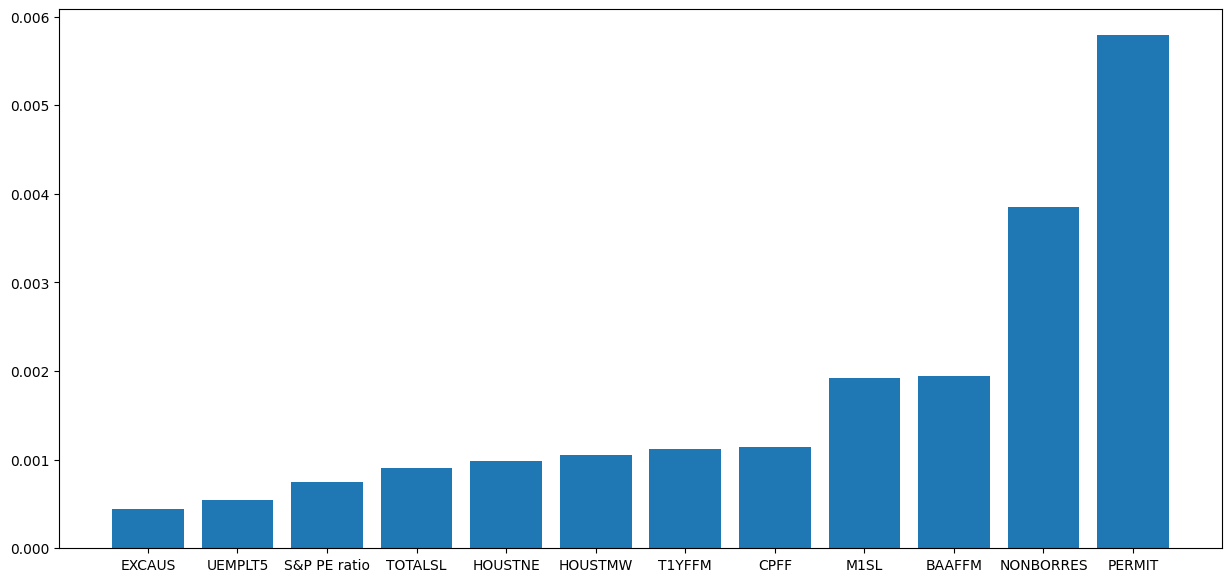

In [5]:
RR_saved.sort_values("RMSE",inplace=True,ascending=True)
USE=RR_saved[~RR_saved.index.isin(['UNRATE'])]
plt.figure(figsize=(15,7))
plt.bar(USE.iloc[-12:].index,USE.iloc[-12:]['RMSE']);
# plt.ylim((-1,len(RR_saved.index)+1))
# plt.plot([.1*RR.max().max(),.1*RR.max().max()],[-1,len(RR.index)+1], '--', color='orange');

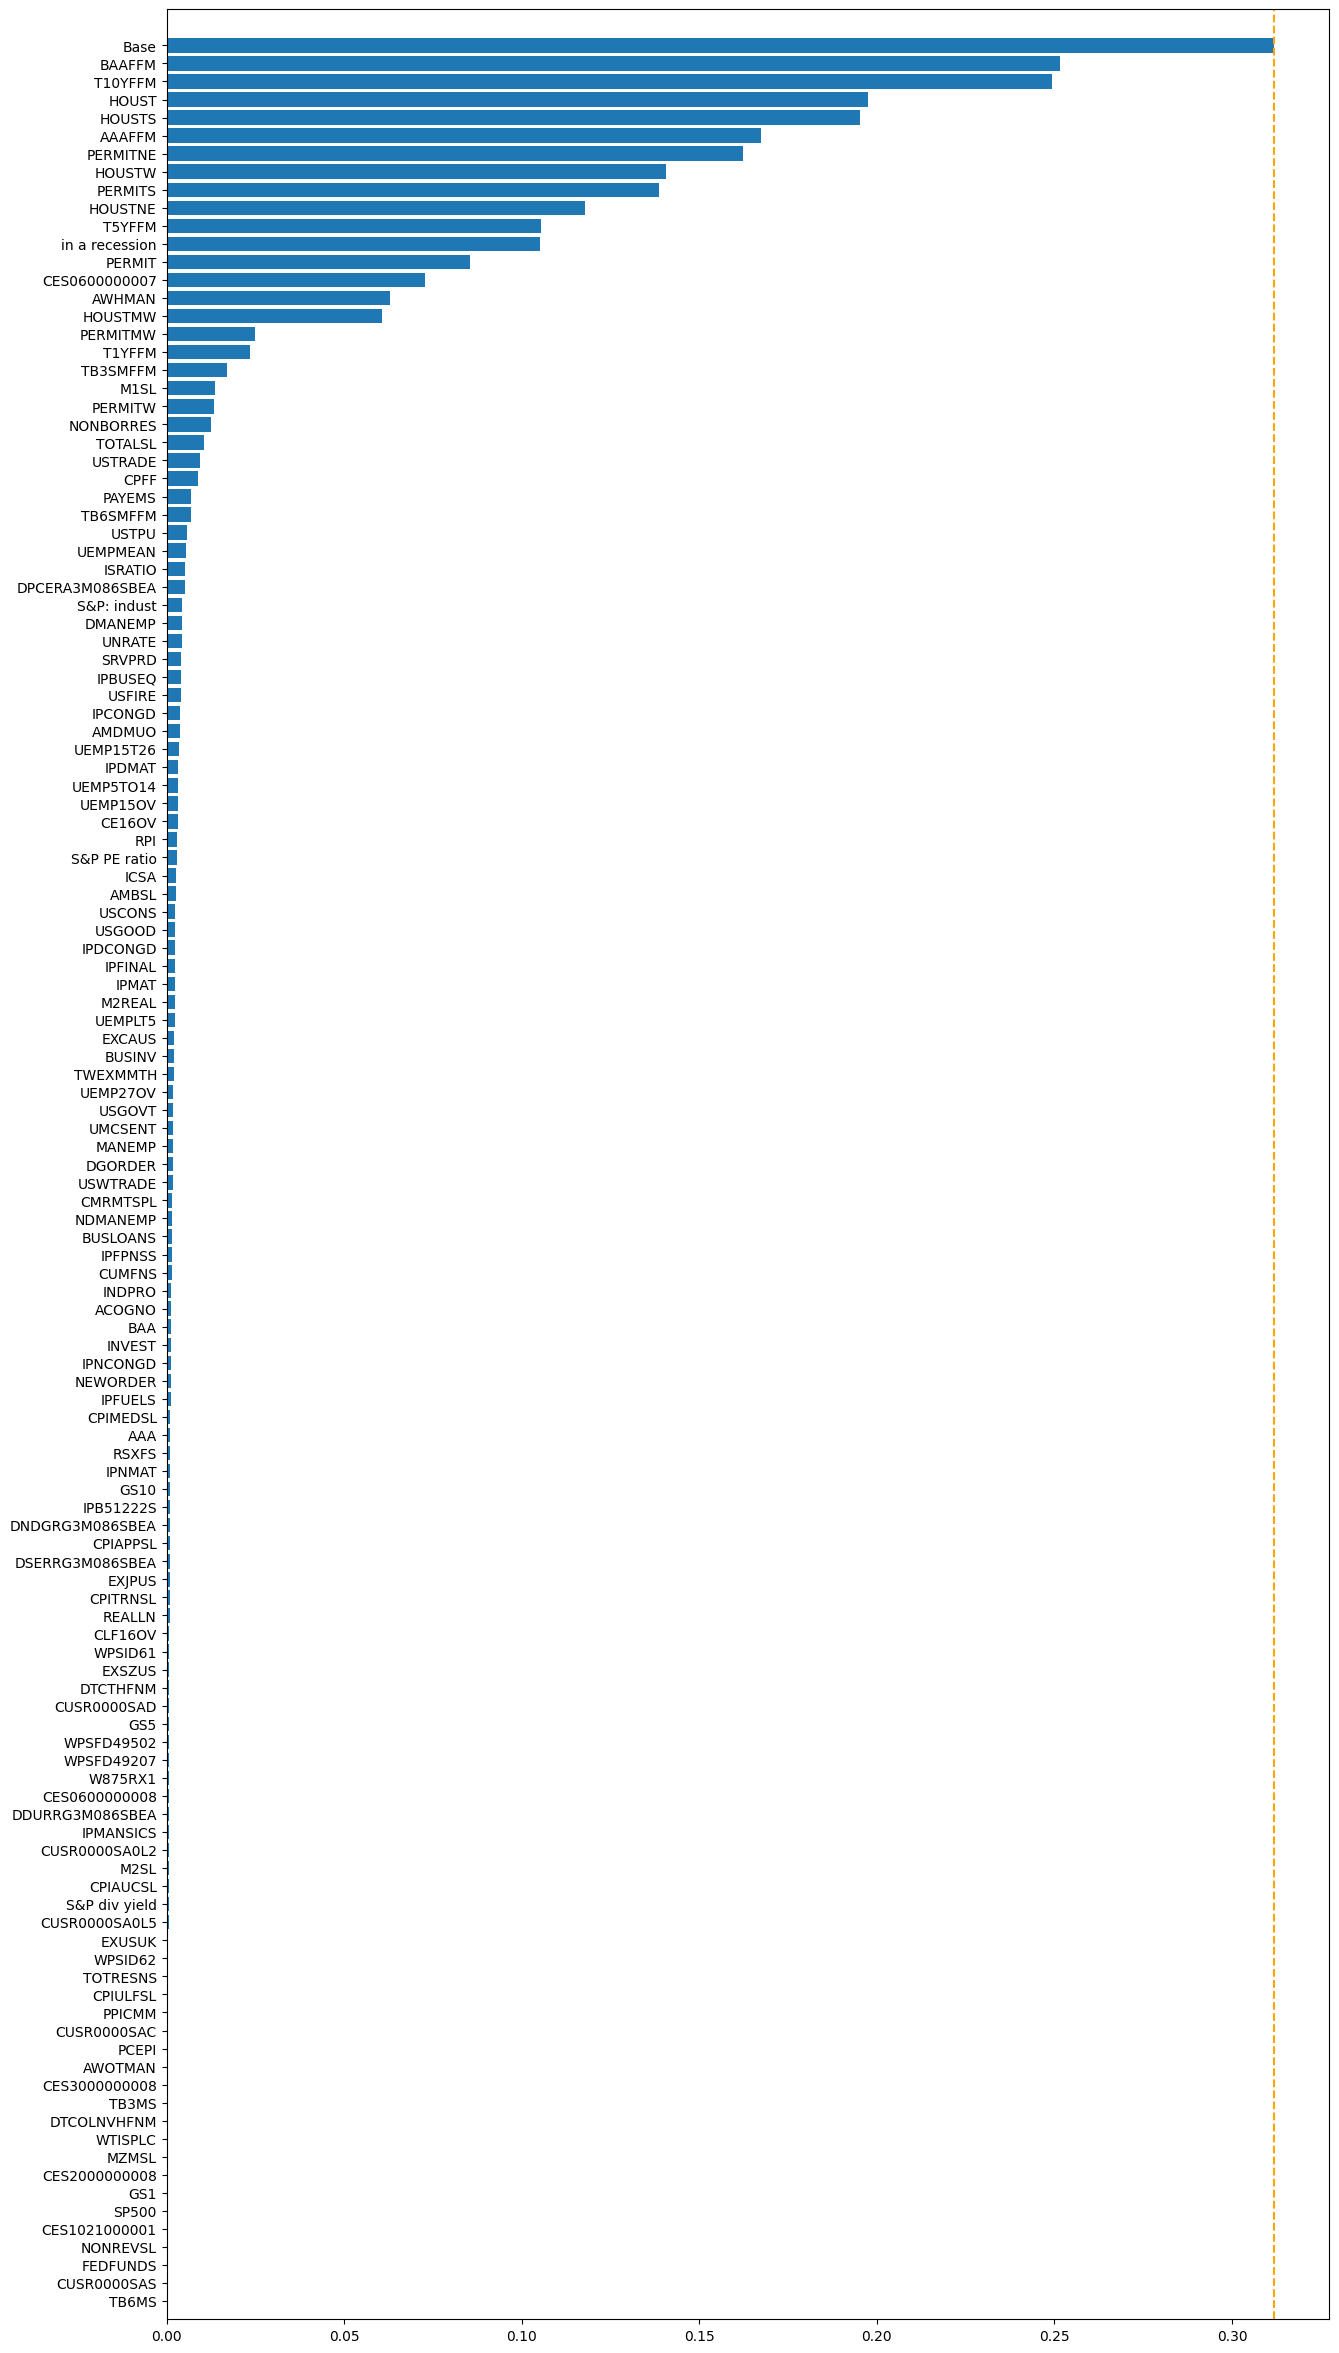

In [ ]:

V.sort_values("MSE_pred",inplace=True,ascending=True)
plt.figure(figsize=(15,30))
plt.barh(V.index,V['MSE_pred'])
plt.ylim((-1,len(V.index)+1))
plt.plot([V.loc['Base','MSE_pred'],V.loc['Base','MSE_pred']],[-1,len(V.index)+1], '--', color='orange',
            label=f"Baseline OOF\nMAE={V.loc['Base','MSE_pred']:.3f}")

In [ ]:
results = []
print(' Computing LSTM feature importance...')

oof_preds =model.predict(testX, verbose=0).squeeze() 
baseline_mae = np.mean(np.abs( oof_preds-testY )**2)
results.append({'feature':'BASELINE','mae':baseline_mae})           
COLS=df.iloc[:,:-1].columns

for k in tqdm(range(len(COLS))):
    
    # SHUFFLE FEATURE K
    save_col = testX[:,:,k].copy()
    np.random.shuffle(testX[:,:,k])
            
    # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
    oof_preds =model.predict(testX, verbose=0)
    mae = np.mean(np.abs( oof_preds-testY )**2)
    results.append({'feature':COLS[k],'mae':mae})
    testX[:,:,k] = save_col
print("done.")


 Computing LSTM feature importance...


  0%|          | 0/125 [00:00<?, ?it/s]

MemoryError: Unable to allocate 77.7 MiB for an array with shape (5433, 30, 125) and data type float32

In [ ]:

# DISPLAY LSTM FEATURE IMPORTANCE
print()
df_R = pd.DataFrame(results)
df_R = df_R.sort_values('mae')
def graph_FM(df_R):
    plt.figure(figsize=(15,30))
    plt.barh(np.arange(len(COLS)+1),df_R.mae)
    plt.yticks(np.arange(len(COLS)+1),df_R.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1,len(COLS)+1))
    plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
            label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
    plt.xlabel(f'OOF MAE with feature permuted',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()
                    
# SAVE LSTM FEATURE IMPORTANCE
df_R = df_R.sort_values('mae',ascending=False)

graph_FM(df_R)

NameError: name 'results' is not defined

In [ ]:
break

--------------- > Fold 1 < ---------------
 Predicting test data...
 Computing LSTM feature importance...


  0%|          | 0/125 [00:00<?, ?it/s]

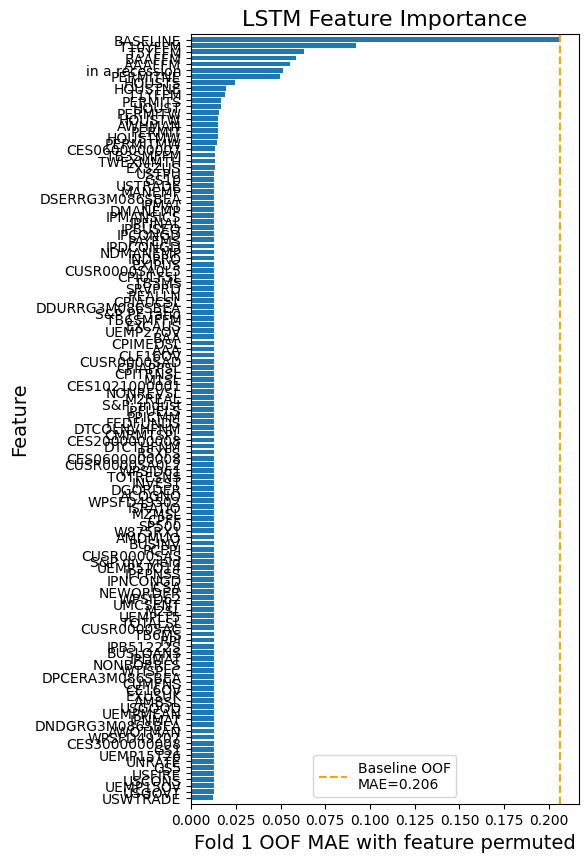

--------------- > Fold 2 < ---------------
 Predicting test data...
 Computing LSTM feature importance...


  0%|          | 0/125 [00:00<?, ?it/s]

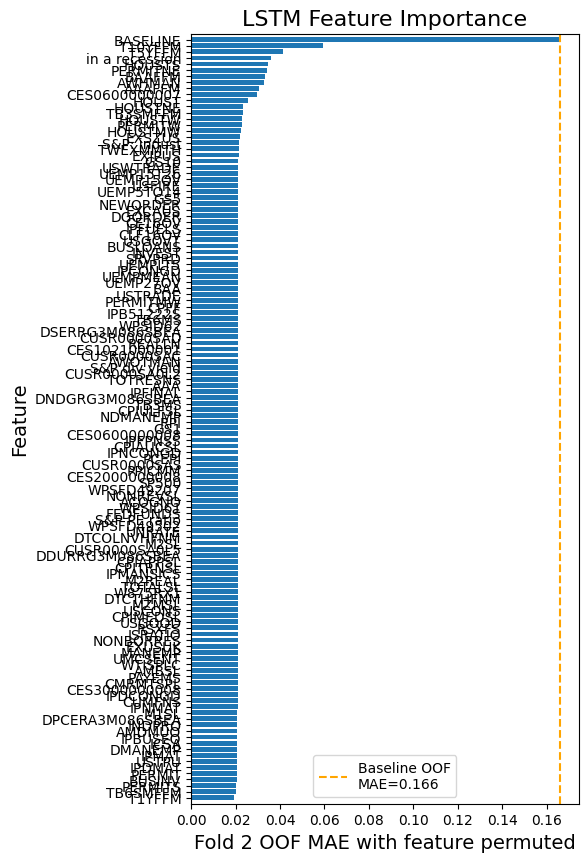

In [ ]:

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=False)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        K.clear_session()
        
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        checkpoint_filepath = f"folds{fold}.hdf5"
        if TRAIN_MODEL:
            model = keras.models.Sequential([
                    Conv1D(filters=32,kernel_size=(3,),activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),)
                    ,Conv1D(filters=32,kernel_size=(3,),activation='relu')
                #   ,Conv1D(filters=32,kernel_size=(3,),activation='relu')
                    ,MaxPool1D(1)
                    ,Dropout(0.1)
                    ,Flatten()
                    ,RepeatVector(1)
                    ,LSTM(100, return_sequences=False)
                    ,Dense(n_forecast,activation='sigmoid'),
                    ])
            model.compile(
                    optimizer='adam',
                    metrics=["mae", 'accuracy','Recall',"AUC"],
                    loss=CustomLoss
                # loss='BinaryCrossentropy'
                )

            model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_data=(X_valid, y_valid), 
                    verbose=1)
        else:
            pass
            # raise Exception("Unknow model")
            # model = keras.models.load_model('../input/finetune-of-tensorflow-bidirectional-lstm/'+checkpoint_filepath)

        if INFER_TEST:
            print(' Predicting test data...')
            test_preds.append(model.predict(testX,verbose=0))
                    
        if COMPUTE_LSTM_IMPORTANCE:
            results = []
            print(' Computing LSTM feature importance...')
            
            # COMPUTE BASELINE (NO SHUFFLE)
            oof_preds =model.predict(X_valid, verbose=0).squeeze() 
            baseline_mae = np.mean(np.abs( oof_preds-y_valid ))
            results.append({'feature':'BASELINE','mae':baseline_mae})           
            COLS=df.iloc[:,:-1].columns
            for k in tqdm(range(len(COLS))):
                
                # SHUFFLE FEATURE K
                save_col = X_valid[:,:,k].copy()
                np.random.shuffle(X_valid[:,:,k])
                        
                # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
                oof_preds =model.predict(X_valid, verbose=0)
                mae = np.mean(np.abs( oof_preds-y_valid ))
                results.append({'feature':COLS[k],'mae':mae})
                X_valid[:,:,k] = save_col
         
            # DISPLAY LSTM FEATURE IMPORTANCE
            print()
            df_R = pd.DataFrame(results)
            df_R = df_R.sort_values('mae')
            plt.figure(figsize=(5,15))
            plt.barh(np.arange(len(COLS)+1),df_R.mae)
            plt.yticks(np.arange(len(COLS)+1),df_R.feature.values)
            plt.title('LSTM Feature Importance',size=16)
            plt.ylim((-1,len(COLS)+1))
            plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
                     label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
            plt.xlabel(f'Fold {fold+1} OOF MAE with feature permuted',size=14)
            plt.ylabel('Feature',size=14)
            plt.legend()
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df_R = df_R.sort_values('mae',ascending=False)
            df_R.to_csv(f'lstm_feature_importance_fold_{fold+1}.csv',index=False)
                               
        # ONLY DO ONE FOLD
        if ONE_FOLD_ONLY: break

In [ ]:
X_valid[:,:,k].shape

(2314, 30)

In [ ]:
df_for_training=df[:"2004"]
df_for_testing=df["2003":]

scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.fillna(0))
# df_for_training_scaled[np.isnan(df_for_training_scaled)] = -1
df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))

trainX_,trainY_=createXY(df_for_training_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
testX_,testY_=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)

165/165 [==============================] - 1s 8ms/step


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

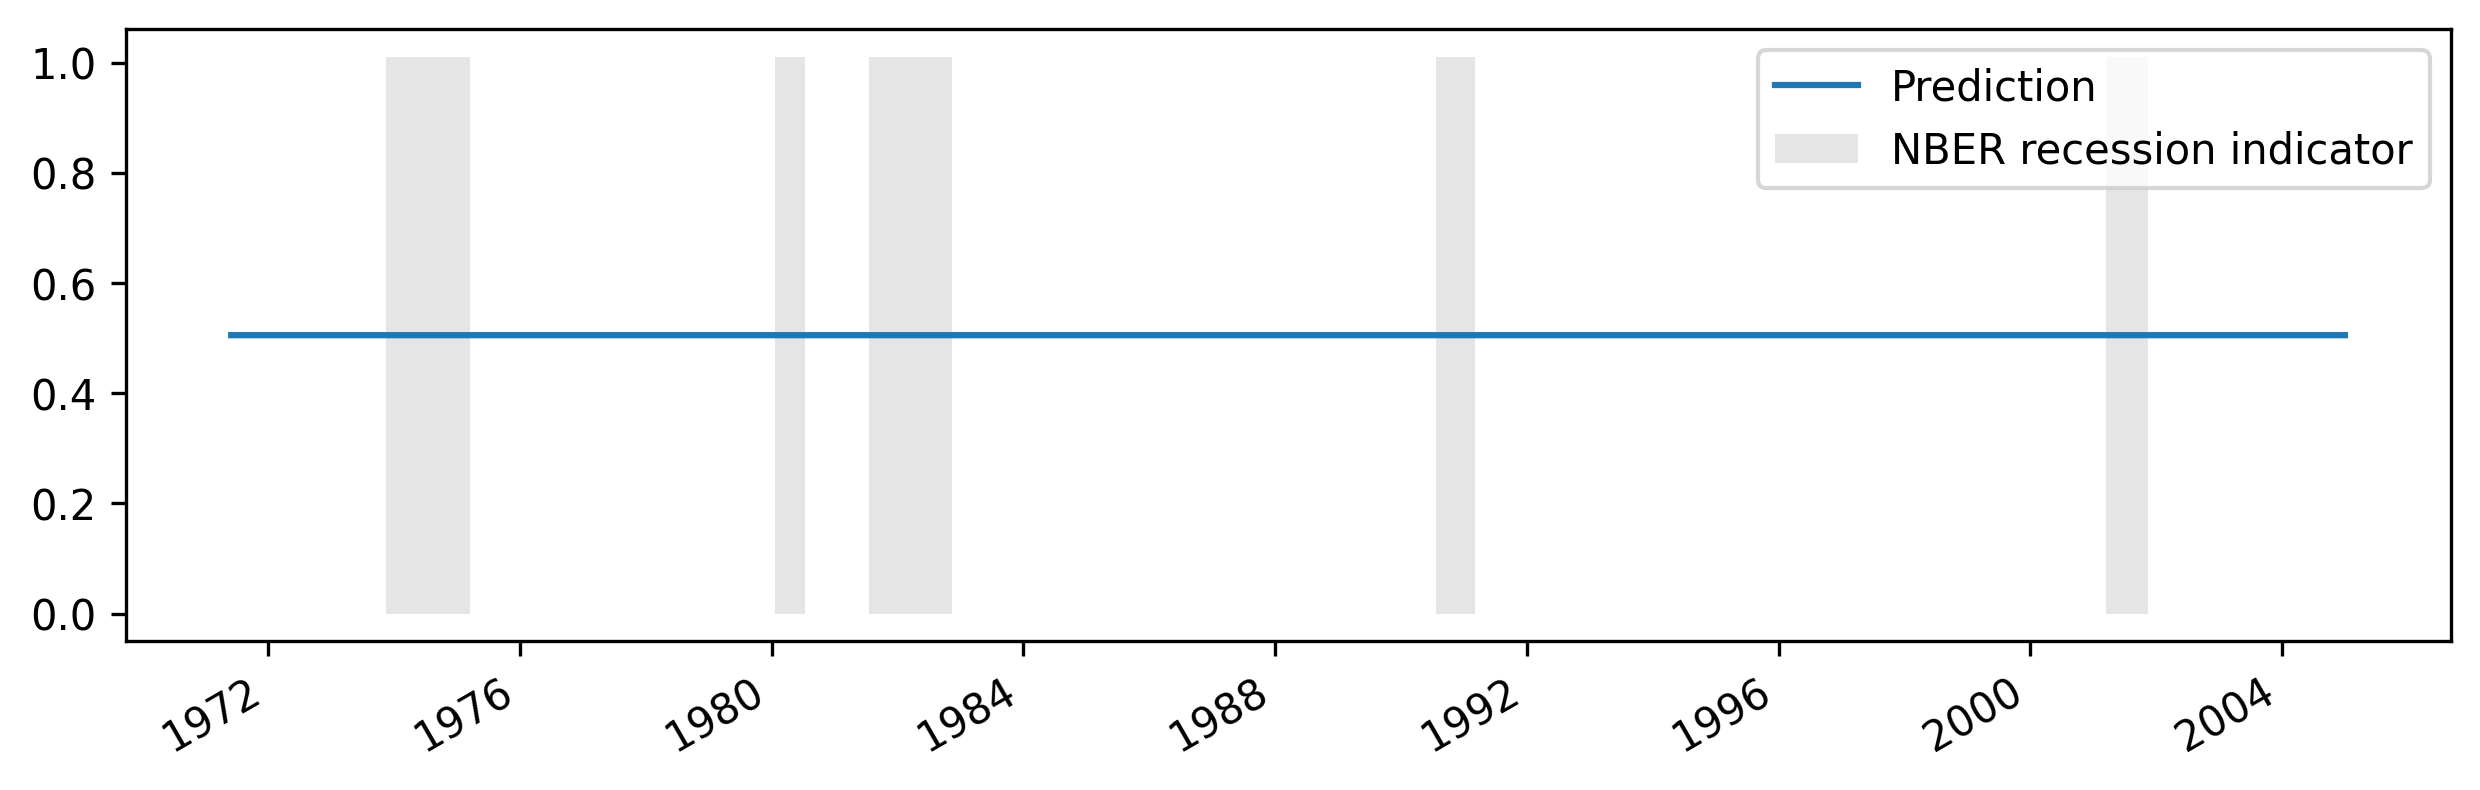

In [ ]:
prediction_train=model.predict(trainX_)
trainResults= pd.DataFrame()
trainResults['Actual']=df_for_training.iloc[-prediction_train.shape[0]:,-2]
trainResults['Pred']=prediction_train
trainResults=trainResults.resample('MS').mean()
plot(tf.math.sigmoid(prediction_train),df_for_training.iloc[-prediction_train.shape[0]:,-2])

200/200 [==============================] - 2s 10ms/step


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

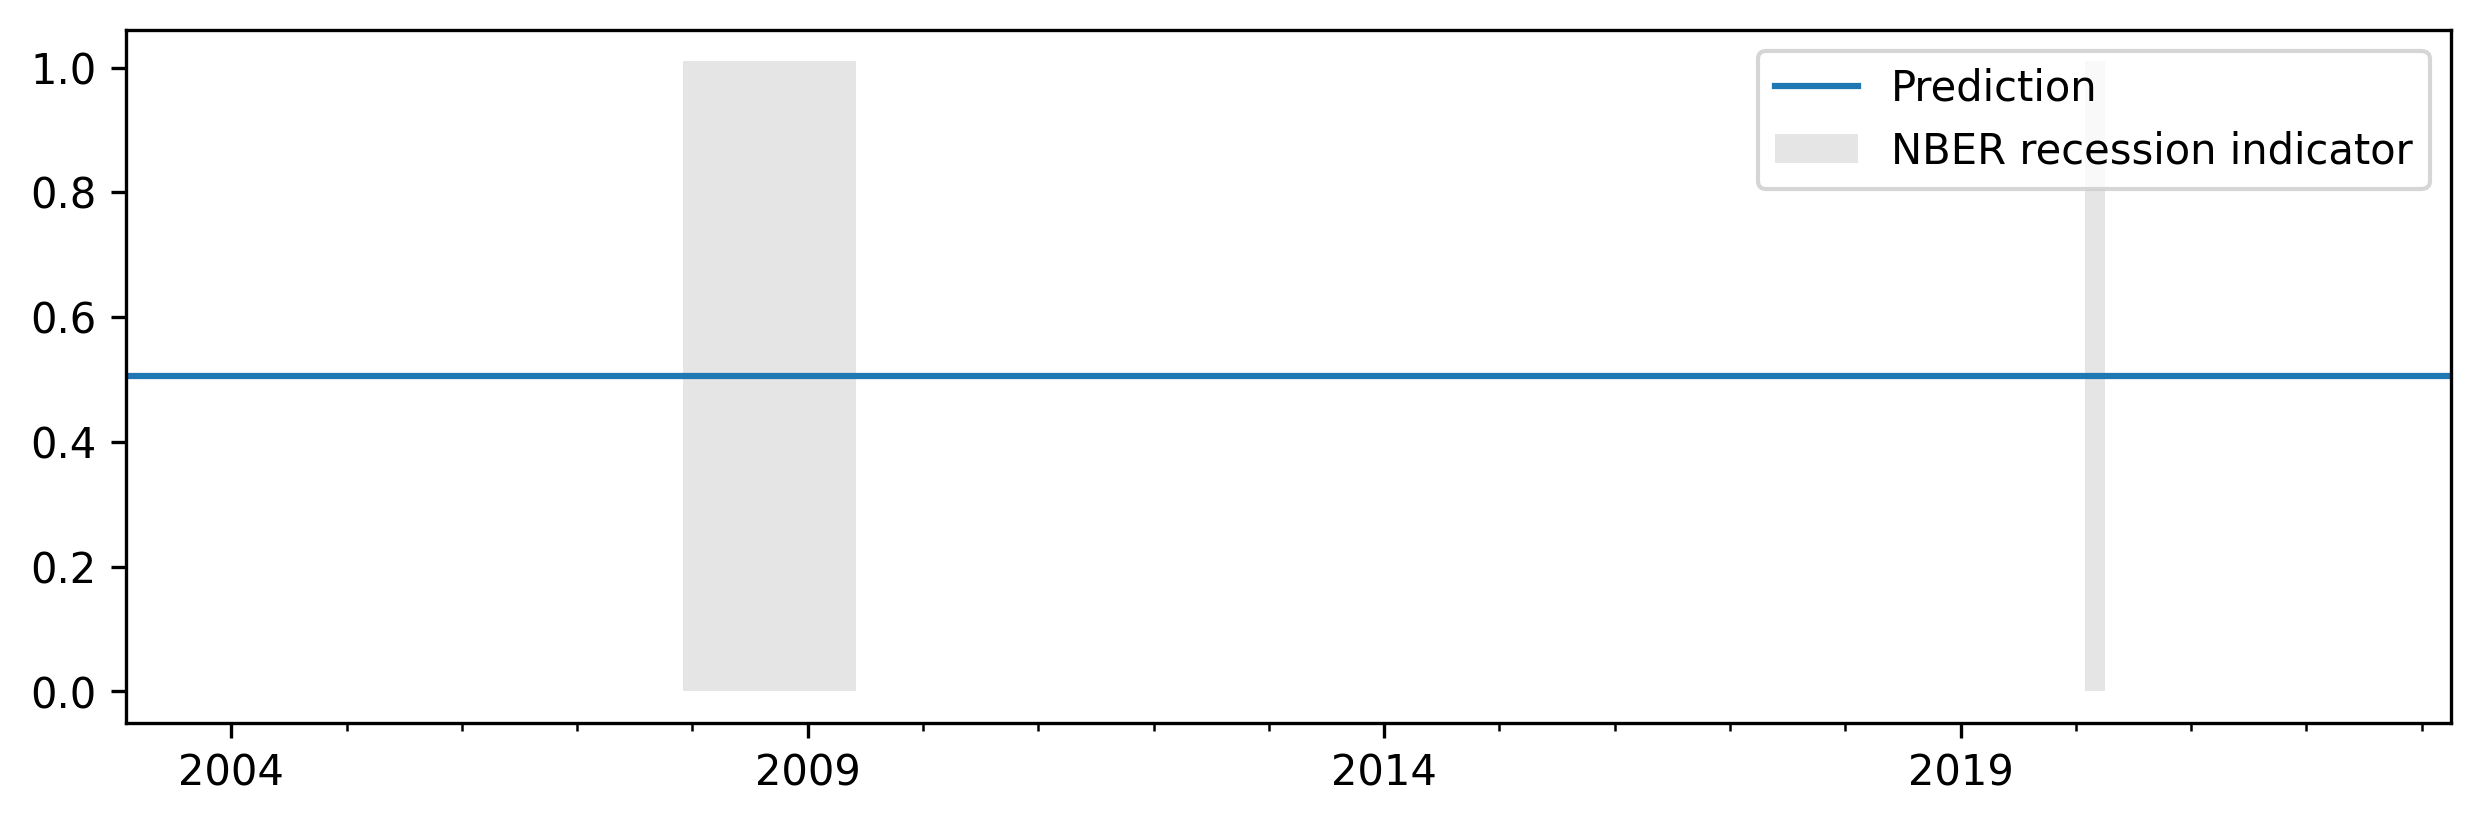

In [ ]:
prediction=model.predict(testX_)
testResults = pd.DataFrame()
testResults['Actual']=df_for_testing.iloc[-prediction.shape[0]:,-2]
testResults["Pred"]=prediction
testResults=testResults.resample('M').max()
plot(tf.math.sigmoid(testResults['Pred']),testResults["Actual"])